In [1]:
!pip install git+https://github.com/PetrochukM/PyTorch-NLP.git

  Cloning https://github.com/PetrochukM/PyTorch-NLP.git to /tmp/pip-req-build-go4o4el8
  Running command git clone -q https://github.com/PetrochukM/PyTorch-NLP.git /tmp/pip-req-build-go4o4el8
  Created wheel for pytorch-nlp: filename=pytorch_nlp-0.5.0-py3-none-any.whl size=88361 sha256=9de4ae2fc3d6c4ac20646c67b5c36fba6e17ab04c4967f9e62675cd7eea38976
  Stored in directory: /tmp/pip-ephem-wheel-cache-m50s_90p/wheels/84/78/c4/66b0b0a3f3973609c6fdd26a91411257c13314b2445c7d83fc
Successfully built pytorch-nlp


In [2]:
from torchnlp.datasets import imdb_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from bs4 import BeautifulSoup

In [3]:
train = imdb_dataset(train=True)
train[:10]

aclImdb_v1.tar.gz: 84.1MB [00:07, 10.7MB/s]                            


[{'sentiment': 'pos',
  'text': 'This movie is now appearing on digital TV at least once a month, I\'ve watched it a dozen or more times, and it never ceases to delight me. If it was on tomorrow I\'d watch it again. Such is the artistry that Peter Ustinov and Maggie Smith, two great magicians of the acting profession can create, helped in no small way by the superb supporting trio of Karl Malden, Bob Newhart and Robert Morley. Not forgetting others in minor roles.<br /><br />It is a simple tale, simply told, of an ex-con, a lovable embezzler, battling and succeeding with the then "new age technology" i.e computers, and finding affection in the process. Even if it is a tad (tongue in cheek) implausible, even unbelievable, the characters are not. There is no violence, no sex, no bad language, and best of all no awful method acting which is so prevalent today. A real lesson to modern movie-makers on how to make a great show from, and with, virtually nothing...except outstanding talent.'},

In [4]:
#create corpus with 'lines_number' number of lines
def create_corpus(dataset, lines_number):
  corpus = []
  for i, diction in enumerate(train):
    corpus.append(diction['text'])
    if i == lines_number - 1:
      return corpus

In [5]:
corpus = create_corpus(train, 50)

In [6]:
print(len(corpus))
corpus[:10]

50


['This movie is now appearing on digital TV at least once a month, I\'ve watched it a dozen or more times, and it never ceases to delight me. If it was on tomorrow I\'d watch it again. Such is the artistry that Peter Ustinov and Maggie Smith, two great magicians of the acting profession can create, helped in no small way by the superb supporting trio of Karl Malden, Bob Newhart and Robert Morley. Not forgetting others in minor roles.<br /><br />It is a simple tale, simply told, of an ex-con, a lovable embezzler, battling and succeeding with the then "new age technology" i.e computers, and finding affection in the process. Even if it is a tad (tongue in cheek) implausible, even unbelievable, the characters are not. There is no violence, no sex, no bad language, and best of all no awful method acting which is so prevalent today. A real lesson to modern movie-makers on how to make a great show from, and with, virtually nothing...except outstanding talent.',
 'I saw "Mystery Men" on my bir

In [7]:
def clean_text(text):
    soup = BeautifulSoup(text)
    text = soup.get_text(separator=' ')
    clean_url = re.compile(r'https?://\S+|www\.\S+')
    text = re.sub(clean_url, ' ', text)
    clean_html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text_nohtml = re.sub(clean_html, ' ', text)
    clean_punctuation = re.compile(r'[^\w\s]')
    text_nopunct = re.sub(clean_punctuation, ' ', text_nohtml)
    clean_spaces = re.compile(r'\s+')
    text_nospaces = re.sub(clean_spaces, ' ', text_nopunct).strip()
    return text_nospaces.lower()

In [8]:
#clear text and lowercased it
corpus = [clean_text(sentence) for sentence in corpus]
corpus[:10]

['this movie is now appearing on digital tv at least once a month i ve watched it a dozen or more times and it never ceases to delight me if it was on tomorrow i d watch it again such is the artistry that peter ustinov and maggie smith two great magicians of the acting profession can create helped in no small way by the superb supporting trio of karl malden bob newhart and robert morley not forgetting others in minor roles it is a simple tale simply told of an ex con a lovable embezzler battling and succeeding with the then new age technology i e computers and finding affection in the process even if it is a tad tongue in cheek implausible even unbelievable the characters are not there is no violence no sex no bad language and best of all no awful method acting which is so prevalent today a real lesson to modern movie makers on how to make a great show from and with virtually nothing except outstanding talent',
 'i saw mystery men on my birthday in 1999 while i was away on vacation whe

In [9]:
#tokenize 
corpus = [sentence.split() for sentence in corpus]

In [10]:
# create vocabulary
vocabulary = set()
for sentence in corpus:
  vocabulary = vocabulary.union(set(sentence))
vocabulary = list(vocabulary)

In [60]:
len(vocabulary)

2893

In [61]:
#create dicts w2idx idx2w
word2idx = {word: i for i, word in enumerate(vocabulary)}
idx2word = {i: word for i, word in enumerate(vocabulary)}

In [62]:
#create list of bigrams
window_size = 2
bigrams = []
words = []
for sentence in corpus:
  length = len(sentence)
  for i, word in enumerate(sentence):
    start_index = 0 if i - window_size <= 0 else i - window_size
    end_index = length - 1 if i + window_size > length - 1 else i + window_size 
    for idx in range(start_index, end_index + 1):
      if idx != i:
        bigrams.append([word2idx[sentence[i]], word2idx[sentence[idx]]])
        words.append([sentence[i],sentence[idx]])

In [63]:
bigrams[:10]

[[296, 1679],
 [296, 332],
 [1679, 296],
 [1679, 332],
 [1679, 2199],
 [332, 296],
 [332, 1679],
 [332, 2199],
 [332, 2632],
 [2199, 1679]]

In [64]:
words[20:40]

[['colors', 'settings'],
 ['great', 'rich'],
 ['great', 'colors'],
 ['great', 'settings'],
 ['great', 'good'],
 ['settings', 'colors'],
 ['settings', 'great'],
 ['settings', 'good'],
 ['settings', 'acting'],
 ['good', 'great'],
 ['good', 'settings'],
 ['good', 'acting'],
 ['good', 'and'],
 ['acting', 'settings'],
 ['acting', 'good'],
 ['acting', 'and'],
 ['acting', 'one'],
 ['and', 'good'],
 ['and', 'acting'],
 ['and', 'one']]

In [65]:
class Word2Vec(nn.Module):
  def __init__(self, embedding_size, vocabulary: list):
      super().__init__()
      self.embedding_size = embedding_size
      self.vocabulary = vocabulary
      self.vocabulary_size = len(self.vocabulary)
      self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
      self.hidden = nn.Linear(self.embedding_size, self.vocabulary_size, bias=False)

      initrange = 0.5 / self.embedding_size
      self.embedding.weight.data.uniform_(-initrange, initrange)
      self.hidden.weight.data.uniform_(0, 0)


  def get_input_layer(self, word_idx):
    x = torch.zeros(self.vocabulary_size).type(torch.LongTensor)
    x[word_idx] = 1.0
    return x

  def forward(self, batch):
        #word_onehot = self.get_input_layer(batch[0])
        word_onehot = torch.LongTensor(batch[0])
        return self.hidden(self.embedding(word_onehot))

  def init_emb(self):
      """
      init the weight as original word2vec do.
      """
      initrange = 0.5 / self.embembedding_size_dim
      self.encoder.weight.data.uniform_(-initrange, initrange)
      self.decoder.weight.data.uniform_(0, 0)

  def get_word_emdedding(self, word, word2idx):
        # word = torch.tensor([word2idx[word]])
        # word = self.get_input_layer(word)
        word = torch.LongTensor([word2idx[word]])
        print(word)
        print(len(word))
        return self.embedding(word)


In [66]:
print(len(bigrams))

45984


In [67]:
len(vocabulary)

2893

In [68]:
def random_batch(skip_grams, batch_size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(skip_grams[i][0])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

In [69]:
type(random_batch(bigrams, 5)[1])

list

In [70]:
epoch = 50000
batch_size = 50
model = Word2Vec(300, vocabulary)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch_num in range(epoch):
    #batch = bigrams[step_idx]
    batch = random_batch(bigrams, batch_size)
    optimizer.zero_grad()
    output = model(batch)
    #loss = criterion(output, model.get_input_layer(batch[1]))
    loss = criterion(output, torch.LongTensor(batch[1]))

    if epoch_num % 100 == 0:
        print('Step:', '%04d' % (epoch_num), 'cost =', '{:.6f}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

Step: 0000 cost = 7.970049
Step: 0100 cost = 7.231958
Step: 0200 cost = 7.448769
Step: 0300 cost = 6.995974
Step: 0400 cost = 6.666851
Step: 0500 cost = 6.899452
Step: 0600 cost = 6.940624
Step: 0700 cost = 6.985084
Step: 0800 cost = 6.550552
Step: 0900 cost = 7.145301
Step: 1000 cost = 5.722373
Step: 1100 cost = 5.535118
Step: 1200 cost = 6.054291
Step: 1300 cost = 6.198102
Step: 1400 cost = 5.765540
Step: 1500 cost = 5.740102
Step: 1600 cost = 6.439470
Step: 1700 cost = 6.239475
Step: 1800 cost = 6.194172
Step: 1900 cost = 6.436218
Step: 2000 cost = 6.385457
Step: 2100 cost = 6.773723
Step: 2200 cost = 5.405581
Step: 2300 cost = 5.726701
Step: 2400 cost = 5.542028
Step: 2500 cost = 5.719489
Step: 2600 cost = 5.883994
Step: 2700 cost = 6.105454
Step: 2800 cost = 6.154086
Step: 2900 cost = 4.653083
Step: 3000 cost = 5.613227
Step: 3100 cost = 6.072093
Step: 3200 cost = 6.053066
Step: 3300 cost = 5.385149
Step: 3400 cost = 5.820079
Step: 3500 cost = 6.825836
Step: 3600 cost = 5.464765
S

In [71]:
embedding = model.get_word_emdedding('colors', word2idx)

tensor([845])
1


In [72]:
embedding

tensor([[ 9.7974e-02,  1.6639e-02,  2.3267e-01,  1.6703e-02, -3.0598e-02,
          7.5276e-02, -2.5279e-02,  3.3310e-02, -8.0594e-03,  5.9232e-02,
         -2.2611e-01,  7.3298e-02, -8.0427e-01, -1.2145e-01, -9.9787e-02,
          2.9965e-01,  1.0587e+00, -6.5935e-02,  6.1857e-02,  6.8610e-02,
          7.8831e-02,  2.5971e-02,  2.8548e-02, -9.2259e-02, -5.8016e-02,
          3.1376e-02, -1.5075e-01,  1.0459e+00,  3.6354e-01,  3.8275e-02,
          1.2703e-01,  3.2810e-03, -2.0799e-02, -7.8145e-03,  2.1987e-01,
          1.0848e-01, -1.5010e-02, -1.3249e-01,  9.2190e-02, -1.1916e-01,
         -1.2871e-01,  1.3079e+00,  1.0225e-01,  4.0510e-02,  6.8250e-03,
         -1.0445e-01,  3.5967e-02, -3.5062e-01,  1.8532e-01,  2.0456e-01,
         -1.7695e-02,  2.7635e-02, -3.4875e-02,  3.3199e-02, -4.8682e-03,
          3.0728e-02, -1.1576e-01,  2.2119e-01,  8.4646e-02,  9.0132e-02,
          2.1792e-02, -5.2669e-02, -3.9004e-01, -1.2172e-01,  5.6627e-01,
          3.3835e-01, -4.5848e-01, -4.

In [73]:
embedding2 = model.get_word_emdedding('small', word2idx)

tensor([2631])
1


In [74]:
len(embedding2[0])

300

In [75]:
word2idx

{'intricate': 0,
 'tunes': 1,
 'longest': 2,
 'strong': 3,
 'graphically': 4,
 'abandoned': 5,
 'hearkening': 6,
 'nobody': 7,
 'episodes': 8,
 'somewhat': 9,
 'male': 10,
 'conclusions': 11,
 'near': 12,
 'typically': 13,
 'assault': 14,
 'produced': 15,
 'boxer': 16,
 'youthful': 17,
 'those': 18,
 'minimal': 19,
 'seems': 20,
 'springs': 21,
 'famous': 22,
 'reconciliation': 23,
 'mistaking': 24,
 'd': 25,
 'bauer': 26,
 'beaten': 27,
 'strands': 28,
 'gadar': 29,
 'marvelous': 30,
 'college': 31,
 'features': 32,
 'just': 33,
 'game': 34,
 'last': 35,
 'sam': 36,
 'town': 37,
 'stitzer': 38,
 'negative': 39,
 'shootout': 40,
 'uniform': 41,
 'different': 42,
 'grass': 43,
 'happy': 44,
 'return': 45,
 'old': 46,
 'melbourne': 47,
 'gaffes': 48,
 'america': 49,
 'unknown': 50,
 'liquor': 51,
 'reynolds': 52,
 'influences': 53,
 'john': 54,
 'gene': 55,
 'luis': 56,
 'recently': 57,
 'reads': 58,
 'certainly': 59,
 'ben': 60,
 'multi': 61,
 'crappy': 62,
 'stumbled': 63,
 'because': 

Выходные данные были обрезаны до нескольких последних строк (5000).
tensor([1643])
1
tensor([1643])
1
tensor([1644])
1
tensor([1644])
1
tensor([1645])
1
tensor([1645])
1
tensor([1646])
1
tensor([1646])
1
tensor([1647])
1
tensor([1647])
1
tensor([1648])
1
tensor([1648])
1
tensor([1649])
1
tensor([1649])
1
tensor([1650])
1
tensor([1650])
1
tensor([1651])
1
tensor([1651])
1
tensor([1652])
1
tensor([1652])
1
tensor([1653])
1
tensor([1653])
1
tensor([1654])
1
tensor([1654])
1
tensor([1655])
1
tensor([1655])
1
tensor([1656])
1
tensor([1656])
1
tensor([1657])
1
tensor([1657])
1
tensor([1658])
1
tensor([1658])
1
tensor([1659])
1
tensor([1659])
1
tensor([1660])
1
tensor([1660])
1
tensor([1661])
1
tensor([1661])
1
tensor([1662])
1
tensor([1662])
1
tensor([1663])
1
tensor([1663])
1
tensor([1664])
1
tensor([1664])
1
tensor([1665])
1
tensor([1665])
1
tensor([1666])
1
tensor([1666])
1
tensor([1667])
1
tensor([1667])
1
tensor([1668])
1
tensor([1668])
1
tensor([1669])
1
tensor([1669])
1
tensor([1670])

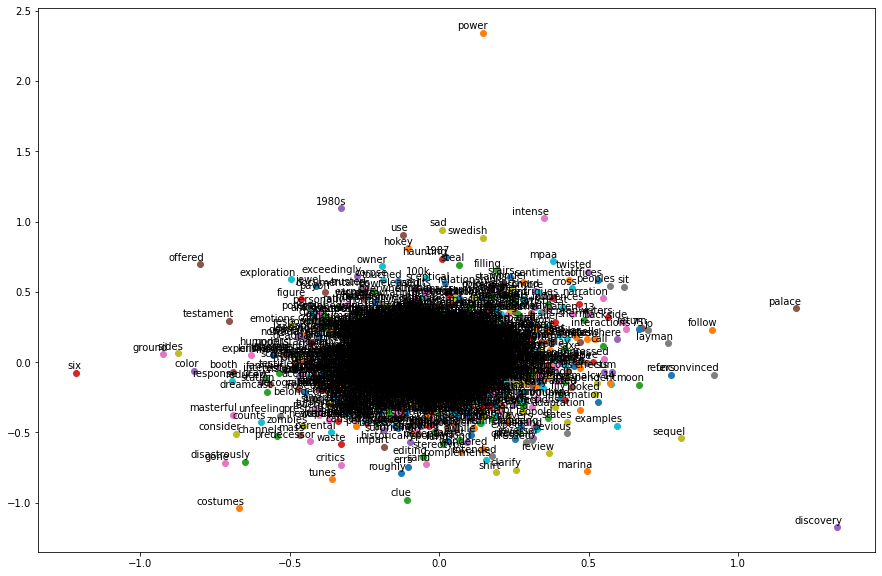

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
for w in vocabulary:
    x = model.get_word_emdedding(w, word2idx).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w, word2idx).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
#from bs4 import BeautifulSoup

class Word2Vec(nn.Module):
  def __init__(self, embedding_size, vocabulary: list):
    super().__init__()
    self.embedding_size = embedding_size
    self.vocabulary = vocabulary
    self.vocabulary_size = len(self.vocabulary)
    self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
    self.hidden = nn.Linear(self.embedding_size, self.vocabulary_size, bias=False)

    initrange = 0.5 / self.embedding_size
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.hidden.weight.data.uniform_(0, 0)


  def get_input_layer(self, word_idx):
    x = torch.zeros(self.vocabulary_size).type(torch.LongTensor)
    x[word_idx] = 1.0
    return x

  def forward(self, batch):
    #word_onehot = self.get_input_layer(batch[0])
    word_onehot = torch.LongTensor(batch[0])
    return self.hidden(self.embedding(word_onehot))

  def init_emb(self):
    """
    init the weight as original word2vec do.
    """
    initrange = 0.5 / self.embembedding_size_dim
    self.encoder.weight.data.uniform_(-initrange, initrange)
    self.decoder.weight.data.uniform_(0, 0)

  def get_word_emdedding(self, word, word2idx):
    # word = torch.tensor([word2idx[word]])
    # word = self.get_input_layer(word)
    word = torch.LongTensor([word2idx[word]])
    return self.embedding(word)

def clean_text(text):
  # soup = BeautifulSoup(text)
  # text = soup.get_text(separator=' ')
  clean_url = re.compile(r'https?://\S+|www\.\S+')
  text = re.sub(clean_url, ' ', text)
  clean_html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  text_nohtml = re.sub(clean_html, ' ', text)
  clean_punctuation = re.compile(r'[^\w\s]')
  text_nopunct = re.sub(clean_punctuation, ' ', text_nohtml)
  clean_spaces = re.compile(r'\s+')
  text_nospaces = re.sub(clean_spaces, ' ', text_nopunct).strip()
  return text_nospaces.lower()

def random_batch(skip_grams, batch_size):
  random_inputs = []
  random_labels = []
  random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

  for i in random_index:
    random_inputs.append(skip_grams[i][0])  # target
    random_labels.append(skip_grams[i][1])  # context word
    return random_inputs, random_labels

def train(data: str):
  #clear text
  corpus = [clean_text(sentence) for sentence in [data]]
  #tokenize it
  corpus = [sentence.split() for sentence in corpus]
  # create vocabulary
  vocabulary = set()
  for sentence in corpus:
    vocabulary = vocabulary.union(set(sentence))
  vocabulary = list(vocabulary)
  #create dicts w2idx idx2w
  word2idx = {word: i for i, word in enumerate(vocabulary)}
  idx2word = {i: word for i, word in enumerate(vocabulary)} 
  #create list of bigrams
  window_size = 3
  bigrams = []
  words = []
  for sentence in corpus:
    length = len(sentence)
    for i, word in enumerate(sentence):
      start_index = 0 if i - window_size <= 0 else i - window_size
      end_index = length - 1 if i + window_size > length - 1 else i + window_size 
      for idx in range(start_index, end_index + 1):
        if idx != i:
          bigrams.append([word2idx[sentence[i]], word2idx[sentence[idx]]])
          words.append([sentence[i],sentence[idx]])
  #train the model
  epoch = 7000
  batch_size = 5
  model = Word2Vec(600, vocabulary)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  for epoch_num in range(epoch):
    #batch = bigrams[step_idx]
    batch = random_batch(bigrams, batch_size)
    optimizer.zero_grad()
    output = model(batch)
    #loss = criterion(output, model.get_input_layer(batch[1]))
    loss = criterion(output, torch.LongTensor(batch[1]))

    if epoch_num % 100 == 0:
      print('Step:', '%04d' % (epoch_num), 'cost =', '{:.6f}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()  

  #create final dict
  embedding_dict = {}
  for word in vocabulary:
    embedding = model.get_word_emdedding(word, word2idx)
    np_embedding = embedding[0].detach().numpy()
    embedding_dict[word] = np_embedding
  return embedding_dict

In [34]:
d = 'This movie is now appearing on digital TV at least once a month, I\'ve watched it a dozen or more times, and it never ceases to delight me. If it was on tomorrow I\'d watch it again. Such is the artistry that Peter Ustinov and Maggie Smith, two great magicians of the acting profession can create, helped in no small way by the superb supporting trio of Karl Malden, Bob Newhart and Robert Morley. Not forgetting others in minor roles.<br /><br />It is a simple tale, simply told, of an ex-con, a lovable embezzler, battling and succeeding with the then "new age technology" i.e computers, and finding affection in the process. Even if it is a tad (tongue in cheek) implausible, even unbelievable, the characters are not. There is no violence, no sex, no bad language, and best'
emb = train(d)

Step: 0000 cost = 4.644391
Step: 0100 cost = 4.617957
Step: 0200 cost = 4.675367
Step: 0300 cost = 4.616598
Step: 0400 cost = 4.502701
Step: 0500 cost = 3.079498
Step: 0600 cost = 4.738028
Step: 0700 cost = 5.212971
Step: 0800 cost = 4.657086
Step: 0900 cost = 4.977295
Step: 1000 cost = 4.056636
Step: 1100 cost = 3.467350
Step: 1200 cost = 3.854365
Step: 1300 cost = 3.804498
Step: 1400 cost = 2.740191
Step: 1500 cost = 1.265079
Step: 1600 cost = 3.238599
Step: 1700 cost = 1.581452
Step: 1800 cost = 3.510905
Step: 1900 cost = 4.135088
Step: 2000 cost = 2.003901
Step: 2100 cost = 4.839202
Step: 2200 cost = 1.916237
Step: 2300 cost = 3.570211
Step: 2400 cost = 2.157136
Step: 2500 cost = 2.317287
Step: 2600 cost = 3.351645
Step: 2700 cost = 3.843224
Step: 2800 cost = 3.630274
Step: 2900 cost = 1.872632
Step: 3000 cost = 1.952718
Step: 3100 cost = 3.241292
Step: 3200 cost = 3.956237
Step: 3300 cost = 2.105314
Step: 3400 cost = 2.045250
Step: 3500 cost = 2.786861
Step: 3600 cost = 2.953363
S

In [33]:
#5000 - проходит
#10000 - time limit
#
#

array([ 4.46093231e-01, -8.30210745e-02, -2.52795629e-02, -3.70927334e-01,
        4.29687679e-01,  2.58878678e-01,  1.14236593e-01, -2.39977613e-01,
        2.63383053e-02,  2.35786766e-01, -2.73606349e-02, -3.99347812e-01,
       -2.61060297e-01,  2.33574212e-01, -4.76272032e-02, -1.48115307e-01,
       -1.77456606e-02,  2.92748779e-01, -2.64230281e-01,  1.11096203e-01,
       -2.87674069e-01, -4.76066470e-01, -1.06610984e-01, -2.92588174e-01,
        1.01630360e-01, -7.23888204e-02, -1.45786762e-01, -1.23112991e-01,
        1.72118858e-01, -8.64257216e-02,  2.94293940e-01,  3.19729030e-01,
        2.25556731e-01,  3.07363480e-01, -4.18204479e-02, -3.38268423e+00,
        1.84348568e-01,  2.83975005e-01,  3.09501618e-01,  9.35791293e-04,
        2.07456946e-01, -4.77443933e-01, -1.14745922e-01, -2.00949803e-01,
       -2.15834156e-01, -2.68801432e-02, -1.11724146e-01,  3.17290664e-01,
       -5.75949192e-01,  2.33597606e-01,  4.35273983e-02,  2.98194200e-01,
        3.27394128e-01,  